### Import Dependencies

In [64]:
import os
import cv2
import timm
import torch
import faiss
import random
import warnings
import numpy as np
import tqdm.auto as tqdm
import albumentations as A
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import faiss.contrib.torch_utils

from model import *
from download_data import config
from collections import Counter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from timeit import default_timer as timer

In [10]:
warnings.filterwarnings("ignore")
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)
random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark_enabled = True

## Dataset & Dataloader
`ImageNet Mean: (0.485, 0.456, 0.406)`  
`ImageNet Std: (0.229, 0.224, 0.225)`

---

In [11]:
def get_picture_statistic(image_path):
    widths = []
    heights = []
    
    for img in os.listdir(image_path):
        im = cv2.imread(os.path.join(image_path, img), cv2.COLOR_BGR2RGB)
        widths.append(im.shape[1])
        heights.append(im.shape[0])

    avg_width = round(sum(widths)/len(widths),2)
    avg_height = round(sum(heights)/len(heights),2)
    max_width = max(widths)
    max_height = max(heights)

    return avg_width, avg_height, max_width, max_height

In [66]:
avg_width, avg_height, max_width, max_height= get_picture_statistic(image_path=f"{config.path}/data_reid/reid_training")
print(f"Average Width: {avg_width}")
print(f"Average Height: {avg_height}")
print(f"Max Width: {max_width}")
print(f"Max Height: {max_height}")

Average Width: 99.52
Average Height: 208.95
Max Width: 321
Max Height: 427


#### Demo Dataset

In [67]:
class DEMO_GALLERY(Dataset):
    def __init__(self, gallery_path, transform):
        super().__init__()
        self.gallery_path = gallery_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.gallery_path))

    def __getitem__(self, item):
        gallery_image_name = os.listdir(self.gallery_path)[item]
        gallery_label = gallery_image_name
        gallery_image = cv2.imread(os.path.join(self.gallery_path, gallery_image_name))
        gallery_image = cv2.cvtColor(gallery_image, cv2.COLOR_BGR2RGB)

        if self.transform:
            transformed = self.transform(image=gallery_image)
            gallery_image = transformed['image']
            gallery_image = gallery_image.astype(np.float32)
            gallery_image = torch.from_numpy(gallery_image)
            gallery_image = torch.permute(gallery_image, (2,0,1))
        else:
            gallery_image = gallery_image.astype(np.float32)
            gallery_image /= 255.
            gallery_image = torch.from_numpy(gallery_image)
            gallery_image = torch.permute(gallery_image, (2,0,1))

        return gallery_image, gallery_label
    
class DEMO_QUERY(Dataset):
    def __init__(self, query_path, transform):
        super().__init__()
        self.query_path = query_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.query_path))

    def __getitem__(self, item):
        query_image_name = os.listdir(self.query_path)[item]
        query_label = query_image_name
        query_image = cv2.imread(os.path.join(self.query_path, query_image_name))
        query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)

        if self.transform:
            transformed = self.transform(image=query_image)
            query_image = transformed['image']
            query_image = query_image.astype(np.float32)
            query_image = torch.from_numpy(query_image)
            query_image = torch.permute(query_image, (2,0,1))
        else:
            query_image = query_image.astype(np.float32)
            query_image /= 255.
            query_image = torch.from_numpy(query_image)
            query_image = torch.permute(query_image, (2,0,1))

        return query_image, query_label

class DEMO_TRAIN(Dataset):
    def __init__(self, path, transform):
        super().__init__()
        self.path = path
        self.transfrom = transform
        self.people_list = sorted(os.listdir(path))
        
    def __len__(self):
        return len(self.people_list)

    def __getitem__(self, item):
        anchor_name = self.people_list[item]
        anchor_id = int(anchor_name[:5])
        anchor = cv2.imread(os.path.join(self.path, anchor_name))
        anchor = cv2.cvtColor(anchor, cv2.COLOR_BGR2RGB)
        
        positive_list = [filename for filename in self.people_list if filename.startswith(anchor_name[:3])]
        positive_name = random.choice(positive_list)
        while positive_name == anchor_name:
            positive_name = random.choice(positive_list)
        positive = cv2.imread(os.path.join(self.path, positive_name))
        positive = cv2.cvtColor(positive, cv2.COLOR_BGR2RGB)

        negative_name = random.choice(self.people_list) 
        negative_id = int(negative_name[:5])
        while negative_id == anchor_id:
            negative_name = random.choice(self.people_list) 
            negative_id = int(negative_name[:5])
        negative = cv2.imread(os.path.join(self.path, negative_name))
        negative = cv2.cvtColor(negative, cv2.COLOR_BGR2RGB)

        set_images = [anchor, positive, negative]

        if self.transfrom:
            for idx, i in enumerate(set_images):
                transformed = self.transfrom(image=i)
                set_images[idx] = transformed['image']
                set_images[idx] = set_images[idx].astype(np.float32)
                set_images[idx] = torch.from_numpy(set_images[idx])
                set_images[idx] = torch.permute(set_images[idx], (2,0,1))
                
        else:
            tf = A.Compose([A.Resize(224,224)])
            for idx, i in enumerate(set_images):
                transformed = tf(image=i)
                set_images[idx] = transformed['image']
                set_images[idx] = set_images[idx].astype(np.float32)
                set_images[idx] /= 255.
                set_images[idx] = torch.from_numpy(set_images[idx])
                set_images[idx] = torch.permute(set_images[idx], (2,0,1))
                

        return set_images[0], set_images[1], set_images[2], anchor_id

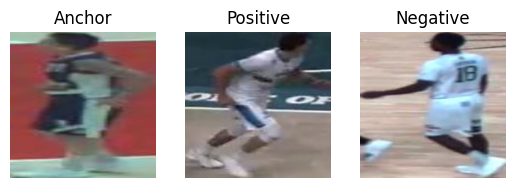

In [69]:
path = f"{config.path}/data_reid/reid_training" 
dataset = DEMO_TRAIN(path=path, transform=None)
anchor, positive, negative, _ = next(iter(dataset))

fig, ax = plt.subplots(1,3)
ax[0].imshow(torch.permute(anchor, (1,2,0)))
ax[1].imshow(torch.permute(positive, (1,2,0)))
ax[2].imshow(torch.permute(negative, (1,2,0)))

for idx, name in enumerate(["Anchor", "Positive", "Negative"]):
    ax[idx].set_title(name)
    ax[idx].axis('off')

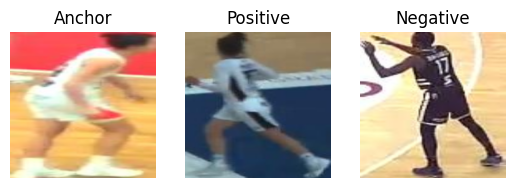

In [70]:
train_set = DataLoader(dataset=dataset, batch_size=64, shuffle=True, pin_memory=False, drop_last=True, num_workers=8)
a, p, n, _ = next(iter(train_set))

fig, ax = plt.subplots(1,3)
ax[0].imshow(torch.permute(a[0], (1,2,0)))
ax[1].imshow(torch.permute(p[0], (1,2,0)))
ax[2].imshow(torch.permute(n[0], (1,2,0)))

for idx, name in enumerate(["Anchor", "Positive", "Negative"]):
    ax[idx].set_title(name)
    ax[idx].axis('off')

## Loss Function
---

In [71]:
def triplet_loss(anchor, positive, negative, margin=1.0):
    positive_distance = ((anchor-positive)**2).sum(1).sqrt()
    negative_distance = ((anchor-negative)**2).sum(1).sqrt()
    loss = torch.relu(margin + positive_distance - negative_distance)
    return loss.mean()

In [72]:
def quadruplet_loss(anchor, positive, negative1, negative2, margin1=2.0, margin2=1.0):
    squarred_distance_pos = (anchor - positive).pow(2).sum(1)
    squarred_distance_neg = (anchor - negative1).pow(2).sum(1)
    squarred_distance_neg_b = (negative1 - negative2).pow(2).sum(1)
    quadruplet_loss = F.relu(margin1 + squarred_distance_pos - squarred_distance_neg) + F.relu(margin2 + squarred_distance_pos - squarred_distance_neg_b)
    return quadruplet_loss.mean()

## Train
---

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConvNextV2_A()
embedding_dim = 1000
epochs = 1
learning_rate = 0.001
criterion = nn.TripletMarginLoss(margin=1.0)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
weight_path = f"./results" 
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95**epoch, verbose=True)

if os.path.isdir(weight_path) == False:
    os.mkdir(weight_path)

Adjusting learning rate of group 0 to 1.0000e-03.


In [79]:
def validation(model, query_dataset, gallery_dataset, gallery_path, embedding_dim, topk): 
    res = faiss.StandardGpuResources()
    faiss_index = faiss.GpuIndexFlatIP(res, embedding_dim)
    model = model.to(device)
    model.eval()

    gallery_list = []
    query_list = []
    matched_list = []
    with torch.no_grad():
        for gallery, labels in gallery_dataset:
            gallery = gallery.to(device)

            outputs = model(gallery)
            faiss.normalize_L2(outputs.cpu().numpy())
            faiss_index.add(outputs)
            for label in labels:
                gallery_list.append(label)
                
    with torch.no_grad():
        for query, label in query_dataset:
            for i in label:
                query_list.append(i)
            query = query.to(device)

            outputs = model(query)
            _, I = faiss_index.search(outputs, topk)
            for x in I:
                tmp = [gallery_list[x[i]] for i in range(topk)]
                matched_list.append(tmp)

    def calculate_map(query_list, matched_list, gallery_path):   
        total_query_gt = 0
        precision = 0
        count = 0
        AP = 0
        mAP = []
        for query_name, matched_name in zip(query_list, matched_list):
            for x in os.listdir(gallery_path):
                if query_name[:3] == x[:3]:
                    total_query_gt += 1

            tmp_total_query_gt = total_query_gt
            for _, i in enumerate(matched_name,start=1):
                count += 1
                if tmp_total_query_gt == 0:
                    break
                elif query_name[:3] == i[:3]:
                    precision += 1
                    tmp_total_query_gt -= 1
                else:
                    continue
                AP += (precision/count)
            mAP.append(AP/total_query_gt)

            AP = 0
            total_query_gt = 0
            precision = 0
            count = 0
            
        return sum(mAP)/len(mAP)
       
    return calculate_map(query_list, matched_list, gallery_path)

In [80]:
def train(model, epochs, criterion, optimizer, lr_scheduler, train_loader, query_dataset, gallery_dataset, gallery_path, embedding_dim, topk, scheduler, fp16):
    print(f"Start Training...")
    if fp16:
        print(f"Training with Mixed Precision...")
    print()
    best_mAP = 0
    changes = 0
    scaler = torch.cuda.amp.GradScaler()
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        for step, (anchor, positive, negative, _) in enumerate(train_loader):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            if fp16:
                with torch.cuda.amp.autocast():
                    anchor_features = model(anchor) 
                    positive_features = model(positive)
                    negative_features = model(negative)
                    loss = criterion(anchor_features, positive_features, negative_features)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                anchor_features = model(anchor) 
                positive_features = model(positive)
                negative_features = model(negative) 

                loss = criterion(anchor_features, positive_features, negative_features)
                loss.backward()
                optimizer.step()

            if (step+1) % 5 == 0:
                print(f"Epoch:[{epoch}/{epochs}] | Step:[{step+1}/{len(train_loader)}] | Loss:{loss.item():.4f}")
        if scheduler:
            lr_scheduler.step()

        mAP = validation(model=model, query_dataset=query_dataset, gallery_dataset=gallery_dataset, gallery_path=gallery_path, embedding_dim=embedding_dim, topk=topk)
        if mAP >= best_mAP:
            print(f"Best mAP is achieved!!")
            print("Saving Best and Latest Model...")
            torch.save(model.state_dict(), os.path.join(weight_path, f"best.pth"))
            changes = mAP - best_mAP
            best_mAP = mAP

        torch.save(model.state_dict(), os.path.join(weight_path, f"latest.pth"))
        print("All Model Checkpoints Saved!")
        print("----------------------------")
        print(f"Best mAP: {best_mAP:.4f}")
        if mAP >= best_mAP:
            print(f"Current mAP: {mAP:.4f} (+{(changes):.4f})")
        elif mAP < best_mAP:
            print(f"Current mAP: {mAP:.4f} (-{(best_mAP-mAP):.4f})")
        print()
    print("Training is finished!")

In [81]:
tf = A.Compose([A.Resize(224,224),
                A.Normalize(mean=(0.485, 0.456, 0.407), std=(0.229, 0.224, 0.225))])

path = f"{config.path}/data_reid/reid_training/" 
dataset = DEMO_TRAIN(path=path, transform=tf)
train_set = DataLoader(dataset=dataset, batch_size=64, shuffle=True, pin_memory=False, drop_last=False, num_workers=8)

In [82]:
tf = A.Compose([A.Resize(224,224),
                A.Normalize(mean=(0.485, 0.456, 0.407), std=(0.229, 0.224, 0.225))])

gallery_path = f"{config.path}/data_reid/reid_test/gallery" 
query_path = f"{config.path}/data_reid/reid_test/query" 
total_gallery_images = len(os.listdir(gallery_path))

query_dataset = DEMO_QUERY(query_path, tf)
gallery_dataset = DEMO_GALLERY(gallery_path, tf)

query_dataset = DataLoader(query_dataset, batch_size=256, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)
gallery_dataset = DataLoader(gallery_dataset, batch_size=256, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)

In [83]:
train(model=model, epochs=epochs, criterion=criterion, optimizer=optimizer, lr_scheduler=lr_scheduler, train_loader=train_set, 
      query_dataset=query_dataset, gallery_dataset=gallery_dataset, gallery_path=gallery_path, embedding_dim=embedding_dim, topk=total_gallery_images, scheduler=False, fp16=True)

Start Training...
Training with Mixed Precision...

Epoch:[0/1] | Step:[5/134] | Loss:3.8805
Epoch:[0/1] | Step:[10/134] | Loss:1.5164
Epoch:[0/1] | Step:[15/134] | Loss:0.9203
Epoch:[0/1] | Step:[20/134] | Loss:1.0223
Epoch:[0/1] | Step:[25/134] | Loss:0.9784
Epoch:[0/1] | Step:[30/134] | Loss:0.9906
Epoch:[0/1] | Step:[35/134] | Loss:1.0557
Epoch:[0/1] | Step:[40/134] | Loss:0.9650
Epoch:[0/1] | Step:[45/134] | Loss:1.0166
Epoch:[0/1] | Step:[50/134] | Loss:0.9855
Epoch:[0/1] | Step:[55/134] | Loss:1.0133
Epoch:[0/1] | Step:[60/134] | Loss:1.0125
Epoch:[0/1] | Step:[65/134] | Loss:1.0051
Epoch:[0/1] | Step:[70/134] | Loss:0.9880
Epoch:[0/1] | Step:[75/134] | Loss:0.9413
Epoch:[0/1] | Step:[80/134] | Loss:1.0329
Epoch:[0/1] | Step:[85/134] | Loss:0.9851
Epoch:[0/1] | Step:[90/134] | Loss:0.9977
Epoch:[0/1] | Step:[95/134] | Loss:1.1857
Epoch:[0/1] | Step:[100/134] | Loss:1.3797
Epoch:[0/1] | Step:[105/134] | Loss:1.6214
Epoch:[0/1] | Step:[110/134] | Loss:1.5253
Epoch:[0/1] | Step:[11

## Inference
---

#### Inference Helper Methods

In [84]:
def inference(model, query_dataset, gallery_dataset, embedding_dim, topk):
    assert topk >= 1

    res = faiss.StandardGpuResources()
    faiss_index = faiss.GpuIndexFlatIP(res, embedding_dim)
    model = model.to(device)
    model.eval()

    gallery_list = []
    query_list = []
    matched_list = []

    inference_time = []
    with torch.no_grad():
        for (gallery, labels) in gallery_dataset:
            gallery = gallery.to(device)
            
            outputs = model(gallery).cpu().numpy()
            faiss.normalize_L2(outputs)
            faiss_index.add(outputs)
            for label in labels:
                gallery_list.append(label)
    
    with torch.no_grad():
        for query, label in query_dataset:
            for i in label:
                query_list.append(i)
            query = query.to(device)

            inference1 = timer()
            outputs = model(query)
            inference2 = timer()
            torch.cuda.synchronize()
            inference_time.append(inference2-inference1)
            
            start1 = timer()
            _, I = faiss_index.search(outputs, topk)
            end1 = timer()
            print(f"Search Elapsed Time: {end1-start1:.5f} seconds")

            for x in I:
                tmp = [gallery_list[x[i]] for i in range(topk)]
                matched_list.append(tmp)

    print(f"Average Inference Time Elapsed: {sum(inference_time)/len(inference_time):.4f} seconds")
                    
    return query_list, matched_list

In [85]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
        buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    print('Model Size: {:.2f}MB'.format(size_all_mb))

In [86]:
query_dataset = DEMO_QUERY(query_path, tf)
gallery_dataset = DEMO_GALLERY(gallery_path, tf)

query_dataset = DataLoader(query_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)
gallery_dataset = DataLoader(gallery_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
inference_dim = 1000
model = ConvNextV2_A()
model.load_state_dict(torch.load(os.path.join(weight_path, "best.pth")))

get_model_size(model)
query_list, matched_list = inference(model=model, query_dataset=query_dataset, gallery_dataset=gallery_dataset, embedding_dim=inference_dim, topk=total_gallery_images)

Model Size: 14.15MB
Search Elapsed Time: 0.00183 seconds
Search Elapsed Time: 0.00030 seconds
Search Elapsed Time: 0.00032 seconds
Search Elapsed Time: 0.00032 seconds
Average Inference Time Elapsed: 0.0109 seconds


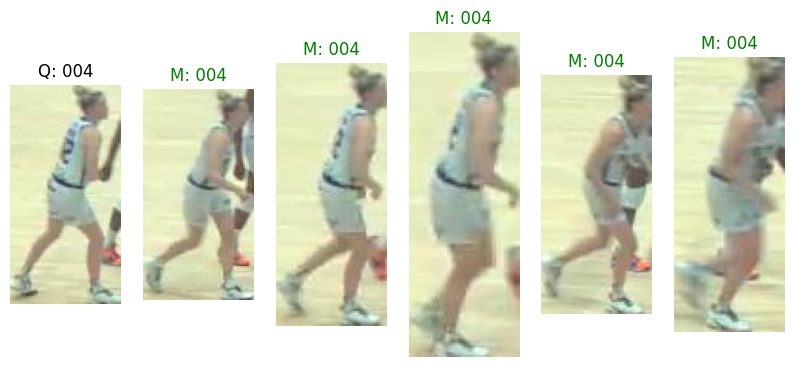

In [87]:
def show_inference(topk, query_list, matched_list, stop=0):
    _, ax = plt.subplots(1,1+topk, figsize=(10,5))
    for step, (query_name, matched_name) in enumerate(zip(query_list, matched_list)):
        # query
        query = cv2.imread(os.path.join(query_path, query_name))
        query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
        ax[0].imshow(query)
        ax[0].set_title(f"Q: {query_name[:3]}")
        ax[0].axis('off')

        # matched
        for i in range(topk):
            matched = cv2.cvtColor(cv2.imread(os.path.join(gallery_path, matched_name[i])), cv2.COLOR_BGR2RGB)
            ax[i+1].imshow(matched)
            ax[i+1].axis('off')
            if int(query_name[:3]) == int(matched_name[i][:3]):
                ax[i+1].set_title(f"M: {matched_name[i][:3]}", color='green')
            else:
                ax[i+1].set_title(f"M: {matched_name[i][:3]}", color='red')
            
        if step == stop:
            break

show_inference(topk=5, query_list=query_list, matched_list=matched_list, stop=3)

## Hard Voting
---

In [ ]:
def hard_voting(matched_list):
    final = []
    tmp = []
    for list in matched_list:
        for j in list:
            tmp.append(int(j[:3]))
        count = Counter(tmp)
        final.append(count.most_common(1)[0][0])
        tmp = []

    return final

hard_voting(matched_list=matched_list)

## Evaluation Metrics
---

### CMC

100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0


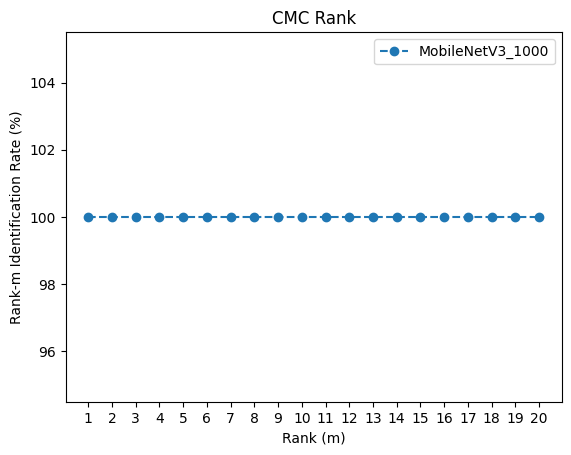

In [89]:
def calculate_cmc(query_list, matched_list, topk):
    count = 0
    total = 0
    rank = []

    for x in range(1, topk+1):
        for (query_name, matched_name) in zip(query_list, matched_list):
            for gallery in matched_name[:x]:
                if query_name[:3] == gallery[:3]:
                    count += 1
                    break
            total += 1
        rank.append((count/total)*100)
        count, total = 0, 0
    return rank

rank = calculate_cmc(query_list=query_list, matched_list=matched_list, topk=20)
for i in rank:
    print(f"{i:.1f}")

x_label = [i for i in range(1, 20+1)]
y_label = rank

plt.plot(x_label, y_label, label=f"MobileNetV3_{embedding_dim}", linestyle="--", marker='o')
plt.title("CMC Rank")
plt.xlabel("Rank (m)")
plt.ylabel("Rank-m Identification Rate (%)")
plt.xticks(range(1,21))
plt.legend()
plt.show()

### mAP

In [90]:
def calculate_map(query_list, matched_list, gallery_path):
    print(f'Number of Queries: {len(query_list)}')
    total_query_gt = 0
    precision = 0
    count = 0
    AP = 0
    mAP = []
    
    for query_name, matched_name in zip(query_list, matched_list):
        for x in os.listdir(gallery_path):
            if query_name[:3] == x[:3]:
                total_query_gt += 1

        tmp_total_query_gt = total_query_gt
        for _, i in enumerate(matched_name,start=1):
            count += 1
            if tmp_total_query_gt == 0:
                break
            elif query_name[:3] == i[:3]:
                precision += 1
                tmp_total_query_gt -= 1
            else:
                continue
            AP += (precision/count)
        mAP.append(AP/total_query_gt)

        AP = 0
        total_query_gt = 0
        precision = 0
        count = 0
        
    print(f"mAP: {(sum(mAP)/len(mAP)):4f}")

calculate_map(query_list=query_list, matched_list=matched_list, gallery_path=gallery_path)

Number of Queries: 50
mAP: 1.000000
